In [1]:
using JSON
using HTML_Entities
using StrTables
using StringEncodings
using Unicode
using Plots

In [2]:
API_Tweets = Dict()
open("Twitter_API_tweets.json", "r") do f
    global API_Tweets
    dicttxt = read(f,String)  # file information to string
    API_Tweets=JSON.parse(dicttxt)  # parse and transform data
end


Dict{String,Any} with 6 entries:
  "Twitter Error" => Any["Two thousand years of error? Pope Francis moves close…
  "Emoji"         => Any["me, tryna tell jae jyp spent over 1M on the emoji:\n\…
  "Zango Text"    => Any[]
  "Unicode"       => Any["Soon to be added to https://t.co/VUHHW9p7dN! Yi Sylla…
  "Tweet Error"   => Any["RT @del_bangtan: BB has become the Allkpp and Kboo of…
  "Emoticons"     => Any["who's the anon flirting with papi....... pLs stop the…

In [3]:
KAGGLE_Tweets_Emoji_Competition = []

for line in eachline(open("tweets_emoji_competition.txt"))
    push!(KAGGLE_Tweets_Emoji_Competition, line)
end

KAGGLE_Tweets_User_Jan = []

for line in eachline(open("tweets_user_jan_2019.txt"))
    push!(KAGGLE_Tweets_User_Jan, line)
end



In [4]:
const EMOTICONS_REGEX = r"""(?x)
            (?:
             [<>]?
             [:;=8]
             [\-o\*\']?
             [\)\]\(\[dDpP/\:\}\{@\|\\]
             |
             [\)\]\(\[dDpP/\:\}\{@\|\\]
             [\-o\*\']?
             [:;=8]
             [<>]?
             |
             <3
            )"""


const URLS = r"""(?x)
        (?:
        https?:
          (?:
            /{1,3}
            |
            [a-z0-9%]
          )
          |
          [a-z0-9.\-]+[.]
          (?:[a-z]{2,13})
          /
        )
        (?:
          [^\s()<>{}\[\]]+
          |
          \([^\s()]*?\([^\s()]+\)[^\s()]*?\)
          |
          \([^\s]+?\)
        )+
        (?:
          \([^\s()]*?\([^\s()]+\)[^\s()]*?\)
          |
          \([^\s]+?\)
          |
          [^\s`!()\[\]{};:'".,<>?«»“”‘’]
        )
        |
        (?:
                (?<!@)
          [a-z0-9]+
          (?:[.\-][a-z0-9]+)*
          [.]
          (?:[a-z]{2,13})
          \b
          /?
          (?!@)
        )
      """


const PHONE_NUMBERS = r"""(?x)
           (?:
             (?:
               \+?[01]
               [ *\-.\)]*
             )?
             (?:
               [\(]?
               \d{3}
               [ *\-.\)]*
             )?
             \d{3}
             [ *\-.\)]*
             \d{4}
           )"""


const HTML_TAGS = r"""<[^>\s]+>"""
const ASCII_ARROWS = r"""[\-]+>|<[\-]+"""
const TWITTER_USERNAME = r"""(?:@[\w_]+)"""
const TWITTER_HASHTAGS = r"""(?:\#+[\w_]+[\w\'_\-]*[\w_]+)"""
const EMAIL_ADDRESSES = r"""[\w.+-]+@[\w-]+\.(?:[\w-]\.?)+[\w-]"""
const WORDS_WITH_APOSTROPHE_DASHES = r"""(?:[^\W\d_](?:[^\W\d_]|['\-_])+[^\W\d_])"""
const NUMBERS_FRACTIONS_DECIMALS = r"""(?:[+\-]?\d+[,/.:-]\d+[+\-]?)"""
const ELLIPSIS_DOTS = r"""(?:\.(?:\s*\.){1,})"""
const WORDS_WITHOUT_APOSTROPHE_DASHES = r"""(?:[\w_]+)"""



const WORD_REGEX = Regex("(?i:" * join([URLS.pattern
                        PHONE_NUMBERS.pattern
                        EMOTICONS_REGEX.pattern
                        HTML_TAGS.pattern
                        ASCII_ARROWS.pattern
                        TWITTER_USERNAME.pattern
                        TWITTER_HASHTAGS.pattern
                        EMAIL_ADDRESSES.pattern
                        WORDS_WITH_APOSTROPHE_DASHES.pattern
                        NUMBERS_FRACTIONS_DECIMALS.pattern
                        WORDS_WITHOUT_APOSTROPHE_DASHES.pattern
                        ELLIPSIS_DOTS.pattern
                        r"(?:\S)".pattern
                        ], "|")
                        * ")"
                    )


const HANG_REGEX = r"""([^a-zA-Z0-9])\1{3,}"""

const HTML_ENTITIES_REGEX = r"""&(#?(x?))([^&;\s]+);"""

const HANDLES_REGEX = r"""(?x)
                (?<![A-Za-z0-9_!@#\$%&*])@(([A-Za-z0-9_]){20}(?!@))
                |
                (?<![A-Za-z0-9_!@#\$%&*])@(([A-Za-z0-9_]){1,19})(?![A-Za-z0-9_]*@)
                """


r"(?x)
(?<![A-Za-z0-9_!@#\$%&*])@(([A-Za-z0-9_]){20}(?!@))
|
(?<![A-Za-z0-9_!@#\$%&*])@(([A-Za-z0-9_]){1,19})(?![A-Za-z0-9_]*@)
"

In [5]:
"""
    replace_html_entities(input_text::AbstractString,
                    remove_illegal=true) => (entities_replaced_text::AbstractString)

Removes entities from text by converting them to their corresponding unicode character.
"""
function replace_html_entities(input_text::AbstractString, parameter; remove_illegal=true)

    function convert_entity(matched_text)
        # HTML entity can be named or encoded in Decimal/Hex form
        # - Named_entity : "&Delta;" => "Δ",
        # - Decimal : "&#916;" => "Δ",
        # - Hex : "&#x394;" => "Δ",
        #
        # However for bytes (hex) 80-9f are interpreted in Windows-1252
        is_numeric_encoded, is_hex_encoded, entity_text = match(HTML_ENTITIES_REGEX,
                                                matched_text).captures
        number = -1

        if isempty(is_numeric_encoded) 
            parameter["Entity_Not_Numeric"] += 1 ################## PARAMETER 1 - Entity_Not_Numeric #############
            return lookupname(HTML_Entities.default, entity_text)
        else
            if isempty(is_hex_encoded) 
                parameter["Entity_Base_10"] += 1 ################## PARAMETER 2 - Entity_Base_10 #################
                is_numeric = all(isdigit, entity_text)
                if is_numeric
                    number = parse(Int, entity_text, base=10)
                end
            else
                parameter["Entity_Base_16"] += 1 ################## PARAMETER 3 - Entity_Base_16 #################
                base_16_letters = ('a', 'b', 'c', 'd', 'e', 'f')
                is_base_16 = all(entity_text) do i
                    isdigit(i) || i in base_16_letters
                end
                if is_base_16
                    number = parse(Int, entity_text, base=16)
                end
            end

            # Numeric character references in the 80-9F range are typically
            # interpreted by browsers as representing the characters mapped
            # to bytes 80-9F in the Windows-1252 encoding. For more info
            # see: https://en.wikipedia.org/wiki/ISO/IEC_8859-1#Similar_character_sets

            if number >= 0
                if 0x80 <= number <= 0x9F 
                    if number ∉ (129, 141, 143, 144, 157) 
                        parameter["Entity_WINDOWS_1252"] += 1 ##### PARAMETER 4 - Entity_WINDOWS-1252 ############
                        return decode([UInt8(number)], "WINDOWS-1252")
                    end
                elseif Unicode.isassigned(number)
                        return Char(number)
                end
            end
        end

        if remove_illegal
            return ""
        else
            return matched_text
        end
    end

    entities_replaced_text = replace(input_text, HTML_ENTITIES_REGEX => convert_entity)
    return entities_replaced_text
end


replace_html_entities

In [6]:
"""
    The key tokenizing function.
"""
function tweet_tokenize(source::AbstractString, parameter;
                            strip_handle=false,
                            reduce_len=false,
                            preserve_case=true)

    
    # Fix HTML Character entities
    ################################################# PARAMETER 1-4  : Based on HTML Entities ####################
    source = replace_html_entities(source, parameter)
    
    if strip_handle ################################# PARAMETER 5 - Strip_Handles ################################
        parameter["Strip_Handles"] += length(collect((m.match for m=eachmatch(HANDLES_REGEX,source,overlap=false))))
        source = replace(source, HANDLES_REGEX => " ")
    end
    
    if reduce_len#################################### PARAMETER 6 - Reduce_len ###################################
        parameter["Reduce_len"] += length(collect(( m.match for m=eachmatch(r"(.)\1{2,}",source,overlap=false))))
        source = replace(source, r"(.)\1{2,}" => s"\1\1\1")
    end
    
    ################################################# PARAMETER 7 - Safe_Text ####################################
    SAFE_PATTERN = r"""([^a-zA-Z0-9])\1{3,}"""
    parameter["Safe_Text"] += length(collect(( m.match for m=eachmatch(SAFE_PATTERN,source,overlap=false))))
    safe_text = replace(source, r"""([^a-zA-Z0-9])\1{3,}""" => s"\1\1\1")
    
    
    tokens = collect((m.match for m in eachmatch(WORD_REGEX,
                                            safe_text,
                                            overlap=false)))
    
    if  !preserve_case
        for (index, word) in enumerate(tokens)
            if !occursin(EMOTICONS_REGEX, word)
                tokens[index] = lowercase(word)
            end
        end
    end

    return tokens
end


tweet_tokenize

In [12]:
"""
The features I am considering to count are:
- Parameter Inside Replace HTML Entities 
1. Entity_Not_Numeric     # This could be something like &amp; => &
2. Entity_Base_10         # Is Base 10 numeric encoded, Like this "&#916;" => "Δ"
3. Entity_Base_16         # Is Base 16 numeric encoded, Like this "&#x394;" => "Δ"
4. Entity_WINDOWS_1252    # Is the entity being interpreted by the browser as 

- Parameter Outside Replace HTML Entities
5. Strip_handles 
6. Reduce_len 
7. Safe_Text 
"""
parameter = Dict{String,Number}()
parameter["Entity_Not_Numeric"] = 0
parameter["Entity_Base_10"] = 0
parameter["Entity_Base_16"] = 0
parameter["Entity_WINDOWS_1252"] = 0
parameter["Strip_Handles"] = 0
parameter["Reduce_len"] = 0
parameter["Safe_Text"] = 0


# Trying out metaprogramming feature
params_list = ["Entity_Not_Numeric" "Entity_Base_10" "Entity_Base_16" "Entity_WINDOWS_1252" "Strip_Handles" "Reduce_len" "Safe_Text" ]
x_label = [1 2 3 4 5 6 7]
frequency_list = Meta.parse("""[parameter["Entity_Not_Numeric"] parameter["Entity_Base_10"] parameter["Entity_Base_16"] parameter["Entity_WINDOWS_1252"] parameter["Strip_Handles"] parameter["Reduce_len"] parameter["Safe_Text"] ]""")
eval(frequency_list)

1×7 Array{Int64,2}:
 0  0  0  0  0  0  0

Dict{String,Number}("Safe_Text"=>0,"Entity_WINDOWS_1252"=>0,"Entity_Base_16"=>0,"Reduce_len"=>2044,"Strip_Handles"=>5897,"Entity_Not_Numeric"=>358,"Entity_Base_10"=>0)


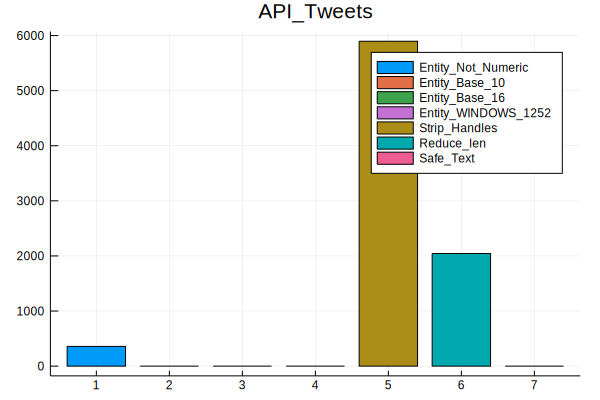

In [22]:
###########################################################################

########################## Count on API_Tweets ############################

###########################################################################

parameter["Entity_Not_Numeric"] = 0
parameter["Entity_Base_10"] = 0
parameter["Entity_Base_16"] = 0
parameter["Entity_WINDOWS_1252"] = 0
parameter["Strip_Handles"] = 0
parameter["Reduce_len"] = 0
parameter["Safe_Text"] = 0

for key in keys(API_Tweets)
#     println(typeof(API_Tweets[key]))
    for tweet in API_Tweets[key]
        tweet_tokenize(tweet,parameter,strip_handle=true,reduce_len=true)
    end
end
println(parameter)
bar(x_label, eval(frequency_list), label=params_list, title = "API_Tweets")

Dict{String,Number}("Safe_Text"=>0,"Entity_WINDOWS_1252"=>0,"Entity_Base_16"=>0,"Reduce_len"=>20037,"Strip_Handles"=>16728,"Entity_Not_Numeric"=>3633,"Entity_Base_10"=>0)


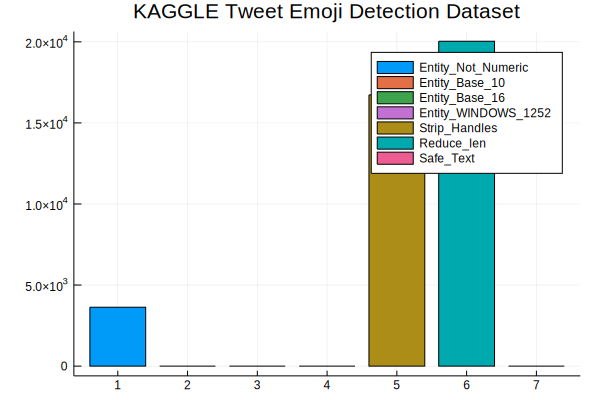

In [23]:
###########################################################################

################# Count on KAGGLE Emoji Competition Dataset ###############

###########################################################################

parameter["Entity_Not_Numeric"] = 0
parameter["Entity_Base_10"] = 0
parameter["Entity_Base_16"] = 0
parameter["Entity_WINDOWS_1252"] = 0
parameter["Strip_Handles"] = 0
parameter["Reduce_len"] = 0
parameter["Safe_Text"] = 0

for tweet in KAGGLE_Tweets_Emoji_Competition
    tweet_tokenize(tweet,parameter,strip_handle=true,reduce_len=true)
end

println(parameter)
bar(x_label, eval(frequency_list), label=params_list, title = "KAGGLE Tweet Emoji Detection Dataset")

Dict{String,Number}("Safe_Text"=>0,"Entity_WINDOWS_1252"=>0,"Entity_Base_16"=>0,"Reduce_len"=>2830,"Strip_Handles"=>4383,"Entity_Not_Numeric"=>11,"Entity_Base_10"=>0)


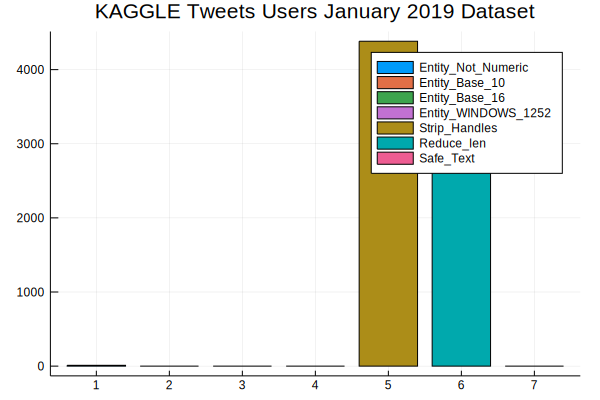

In [24]:
###########################################################################

############## Count on KAGGLE Tweets Users January 2019 Dataset ##########

###########################################################################

parameter["Entity_Not_Numeric"] = 0
parameter["Entity_Base_10"] = 0
parameter["Entity_Base_16"] = 0
parameter["Entity_WINDOWS_1252"] = 0
parameter["Strip_Handles"] = 0
parameter["Reduce_len"] = 0
parameter["Safe_Text"] = 0

for tweet in KAGGLE_Tweets_User_Jan
    tweet_tokenize(tweet,parameter,strip_handle=true,reduce_len=true)
end
println(parameter)
bar(x_label, eval(frequency_list), label=params_list, title = "KAGGLE Tweets Users January 2019 Dataset")

Dict{String,Number}("Safe_Text"=>0,"Entity_WINDOWS_1252"=>1,"Entity_Base_16"=>1,"Reduce_len"=>0,"Strip_Handles"=>0,"Entity_Not_Numeric"=>0,"Entity_Base_10"=>2)


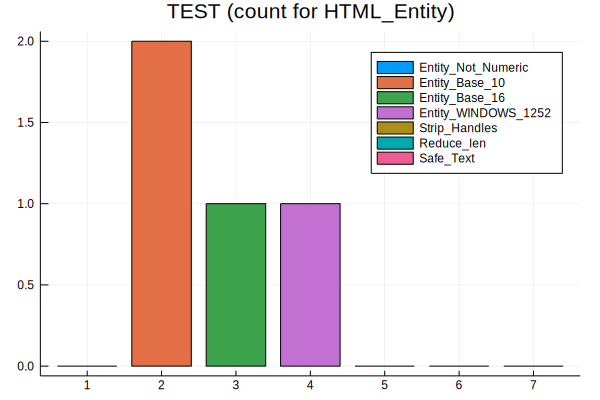

In [25]:
############### Testing with self made strings #####################

parameter["Entity_Not_Numeric"] = 0
parameter["Entity_Base_10"] = 0
parameter["Entity_Base_16"] = 0
parameter["Entity_WINDOWS_1252"] = 0
parameter["Strip_Handles"] = 0
parameter["Reduce_len"] = 0
parameter["Safe_Text"] = 0

tweet_tokenize("&#916; Check if the count thing works for Base10 . This one too Hexa Base -> &#x394; . Also the windows one - &#130;",parameter,strip_handle=true,reduce_len=true)
println(parameter) # NOTE : for token &#130; above, it uses both "Entity_Base_10" as well as "Entity_WINDOWS_1252"
bar(x_label, eval(frequency_list), label=params_list, title = "TEST (count for HTML_Entity)")